In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns

# Đọc file CSV
df_jd = pd.read_csv('../data/clean/clean_jobs_v2.csv')
df_cr = pd.read_csv('../data/clean/clean_resumes_v2.csv')

print(f"Số lượng Job Descriptions: {len(df_jd)}")
print(f"Số lượng Candidate Resumes: {len(df_cr)}")
print(f"\nCột trong JD: {df_jd.columns.tolist()}")
print(f"Cột trong CR: {df_cr.columns.tolist()}")

Số lượng Job Descriptions: 841
Số lượng Candidate Resumes: 690

Cột trong JD: ['id', 'title', 'company', 'location', 'salary', 'description', 'requirements', 'skills', 'language', 'skills_en', 'description_en', 'requirements_en', 'description_cleaned', 'requirements_cleaned', 'skills_cleaned', 'location_group', 'type_salary', 'primary_skills', 'secondary_skills', 'adjectives', 'adverbs']
Cột trong CR: ['Category', 'Resume', 'resume_cleaned', 'primary_skills', 'secondary_skills', 'adjectives', 'adverbs', 'id']


In [2]:

# Hàm chuyển đổi an toàn: xử lý cả chuỗi và danh sách
def safe_literal_eval(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return []
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def assign_suitability(score):
    if score > 0.6:
        return 'Most Suitable'
    elif score > 0.1:
        return 'Moderately Suitable'
    else:
        return 'Not Suitable'



In [3]:

# Chuyển các cột từ chuỗi sang list
for col in ['primary_skills', 'secondary_skills', 'adjectives', 'adverbs']:
    df_jd[col] = df_jd[col].apply(safe_literal_eval)
    df_cr[col] = df_cr[col].apply(safe_literal_eval)

# Tính similarity
similarity_scores = []
for _, jd in df_jd.iterrows():
    for _, cr in df_cr.iterrows():
        primary_sim = jaccard_similarity(jd['primary_skills'], cr['primary_skills'])
        secondary_sim = jaccard_similarity(jd['secondary_skills'], cr['secondary_skills'])
        adj_sim = jaccard_similarity(jd['adjectives'], cr['adjectives'])
        adj_weight = len(cr['adjectives']) if cr['adjectives'] else 1  # tránh nhân 0

        total_sim = primary_sim + secondary_sim + (adj_sim * adj_weight)

        scores = {
            'jd_id': jd['id'],
            'jd_name': jd['title'],
            'cr_id': cr['id'],
            'cr_category': cr['Category'],
            'primary_skills_sim': primary_sim,
            'secondary_skills_sim': secondary_sim,
            'adjectives_sim': adj_sim,
            'adj_weight': adj_weight,
            'total_similarity': total_sim,
            'suitability': assign_suitability(total_sim)
        }
        similarity_scores.append(scores)

df_similarity = pd.DataFrame(similarity_scores)

# Lọc nếu cần: loại các dòng không có primary_sim
df_similarity = df_similarity[df_similarity['primary_skills_sim'] > 0]

# Lưu kết quả
df_similarity.to_csv('jd_cr_similarity.csv', index=False)

# Hiển thị 10 dòng đầu
print(df_similarity[['jd_id', 'jd_name', 'cr_id' ,'cr_category', 'total_similarity', 'suitability']].head(10))

   jd_id         jd_name        cr_id   cr_category  total_similarity  \
0  JOB_0  MLops Engineer  CANDIDATE_0  Data Science          1.341837   
1  JOB_0  MLops Engineer  CANDIDATE_1  Data Science          0.416667   
2  JOB_0  MLops Engineer  CANDIDATE_2  Data Science          0.444444   
3  JOB_0  MLops Engineer  CANDIDATE_3  Data Science          0.277778   
4  JOB_0  MLops Engineer  CANDIDATE_4  Data Science          0.181818   
5  JOB_0  MLops Engineer  CANDIDATE_5  Data Science          0.153846   
6  JOB_0  MLops Engineer  CANDIDATE_6  Data Science          0.166667   
7  JOB_0  MLops Engineer  CANDIDATE_7  Data Science          0.358974   
8  JOB_0  MLops Engineer  CANDIDATE_8  Data Science          0.133333   
9  JOB_0  MLops Engineer  CANDIDATE_9  Data Science          0.166667   

           suitability  
0        Most Suitable  
1  Moderately Suitable  
2  Moderately Suitable  
3  Moderately Suitable  
4  Moderately Suitable  
5  Moderately Suitable  
6  Moderately Suitabl


Kết quả Similarity Sample:
   jd_id         jd_name        cr_id   cr_category  primary_skills_sim  \
0  JOB_0  MLops Engineer  CANDIDATE_0  Data Science            0.178571   
1  JOB_0  MLops Engineer  CANDIDATE_1  Data Science            0.166667   
2  JOB_0  MLops Engineer  CANDIDATE_2  Data Science            0.222222   
3  JOB_0  MLops Engineer  CANDIDATE_3  Data Science            0.111111   
4  JOB_0  MLops Engineer  CANDIDATE_4  Data Science            0.181818   
5  JOB_0  MLops Engineer  CANDIDATE_5  Data Science            0.153846   
6  JOB_0  MLops Engineer  CANDIDATE_6  Data Science            0.166667   
7  JOB_0  MLops Engineer  CANDIDATE_7  Data Science            0.192308   
8  JOB_0  MLops Engineer  CANDIDATE_8  Data Science            0.133333   
9  JOB_0  MLops Engineer  CANDIDATE_9  Data Science            0.166667   

   secondary_skills_sim  total_similarity          suitability  
0              0.285714          1.341837        Most Suitable  
1              0

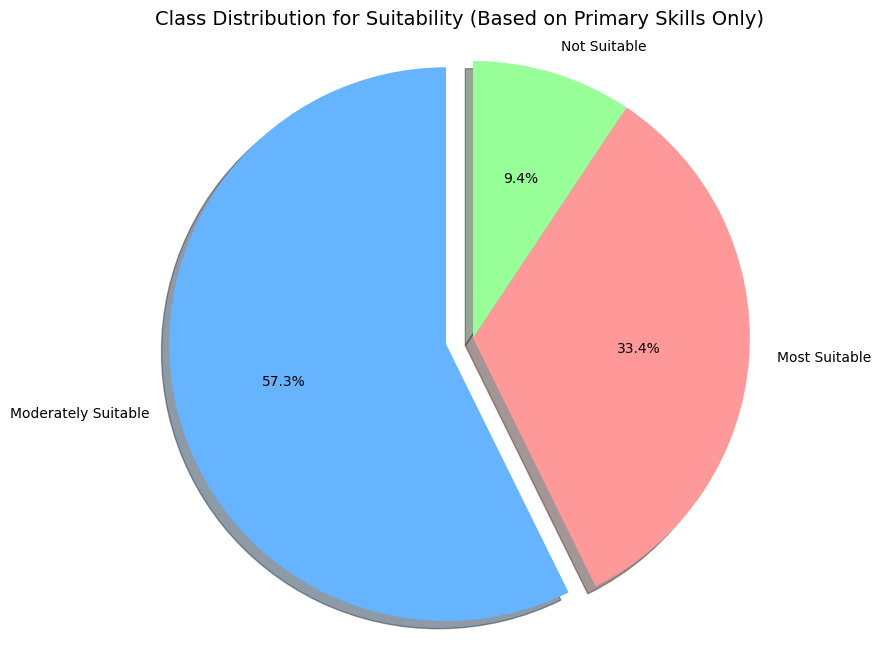


=== SUMMARY ===
Total JD records: 841
Total CR records: 690
Total similarity pairs: 280865
Match rate: 0.00%
Neutral rate: 0.00%
Mismatch rate: 0.00%


In [4]:
print("\nKết quả Similarity Sample:")
print(df_similarity[['jd_id', 'jd_name', 'cr_id', 'cr_category', 'primary_skills_sim','secondary_skills_sim', 'total_similarity', 'suitability']].head(10))

# Kiểm tra phân bố nhãn
class_counts = df_similarity['suitability'].value_counts()
print("\nPhân bố nhãn Suitability:")
print(class_counts)
print(f"\nTổng số cặp JD-CR: {len(df_similarity)}")

# Thống kê điểm similarity
print(f"\nThống kê Primary Skills Similarity:")
print(f"Mean: {df_similarity['primary_skills_sim'].mean():.4f}")
print(f"Median: {df_similarity['primary_skills_sim'].median():.4f}")
print(f"Min: {df_similarity['primary_skills_sim'].min():.4f}")
print(f"Max: {df_similarity['primary_skills_sim'].max():.4f}")

# Tạo explode động cho biểu đồ
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999', '#99ff99'][:len(labels)]
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Class Distribution for Suitability (Based on Primary Skills Only)', fontsize=14)
plt.axis('equal')
plt.savefig('class_distribution_suitability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SUMMARY ===")
print(f"Total JD records: {len(df_jd)}")
print(f"Total CR records: {len(df_cr)}")
print(f"Total similarity pairs: {len(df_similarity)}")
print(f"Match rate: {(class_counts.get('Match', 0) / len(df_similarity) * 100):.2f}%")
print(f"Neutral rate: {(class_counts.get('Neutral', 0) / len(df_similarity) * 100):.2f}%")
print(f"Mismatch rate: {(class_counts.get('Mismatch', 0) / len(df_similarity) * 100):.2f}%")

In [5]:
df_similarity.to_csv('jd_cr_similarity.csv', index=False)

In [6]:
# Lấy 20 dòng đầu tiên có điểm primary_skills_sim cao nhất
top_20_similarities = df_similarity.sort_values(by='primary_skills_sim', ascending=False).head(10000)

# In ra các cột cần thiết
print(top_20_similarities[['jd_id', 'cr_category', 'primary_skills_sim','secondary_skills_sim', 'total_similarity', 'suitability']])


          jd_id          cr_category  primary_skills_sim  \
331623  JOB_489   Operations Manager                 1.0   
272754  JOB_397       Civil Engineer                 1.0   
189264  JOB_275       Civil Engineer                 1.0   
408233  JOB_605   Operations Manager                 1.0   
289963  JOB_423  Mechanical Engineer                 1.0   
...         ...                  ...                 ...   
449292  JOB_676             Advocate                 0.5   
449288  JOB_676             Advocate                 0.5   
449282  JOB_676             Advocate                 0.5   
449278  JOB_676             Advocate                 0.5   
449270  JOB_676                   HR                 0.5   

        secondary_skills_sim  total_similarity          suitability  
331623                   0.0          4.463918        Most Suitable  
272754                   0.0          1.000000        Most Suitable  
189264                   0.0          1.785714        Most Suitable  

In [7]:
pd.DataFrame(df_similarity)

,jd_id,jd_name,cr_id,cr_category,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity,suitability
0,JOB_0,MLops Engineer,CANDIDATE_0,Data Science,0.178571,0.285714,0.020408,43,1.341837,Most Suitable
1,JOB_0,MLops Engineer,CANDIDATE_1,Data Science,0.166667,0.250000,0.000000,7,0.416667,Moderately Suitable
2,JOB_0,MLops Engineer,CANDIDATE_2,Data Science,0.222222,0.222222,0.000000,16,0.444444,Moderately Suitable
3,JOB_0,MLops Engineer,CANDIDATE_3,Data Science,0.111111,0.166667,0.000000,43,0.277778,Moderately Suitable
4,JOB_0,MLops Engineer,CANDIDATE_4,Data Science,0.181818,0.000000,0.000000,1,0.181818,Moderately Suitable
...,...,...,...,...,...,...,...,...,...,...
580276,JOB_989,Senior Fullstack NodeJS & ReactJS Developer (E...,CANDIDATE_812,ETL Developer,0.111111,0.000000,0.000000,35,0.111111,Moderately Suitable
580281,JOB_989,Senior Fullstack NodeJS & ReactJS Developer (E...,CANDIDATE_817,ETL Developer,0.111111,0.000000,0.000000,35,0.111111,Moderately Suitable
580286,JOB_989,Senior Fullstack NodeJS & ReactJS Developer (E...,CANDIDATE_822,ETL Developer,0.111111,0.000000,0.000000,35,0.111111,Moderately Suitable
580288,JOB_989,Senior Fullstack NodeJS & ReactJS Developer (E...,CANDIDATE_824,DotNet Developer,0.333333,0.000000,0.000000,5,0.333333,Moderately Suitable
